# Bayesian Logistic Regression from First Princples



## Reader guide

This notebook demonstrates a **from-scratch implementation of Bayesian logistic regression**
using NumPy, with uncertainty estimated via a Laplace approximation.

**If you have limited time:**
- Jump to **Results and comparison** to see how the implementation matches scikit-learn.
- Skim **From-scratch building blocks** to understand what was implemented manually.

**What this notebook covers:**
- MAP estimation via Newton’s method
- Laplace approximation of the posterior
- Posterior predictive inference via Monte Carlo
- Sanity-check comparison against a standard library implementation

Planned future notebooks will include:
- Full posterior sampling via Markov Chain Monte Carlo with emphasis on reproducibility and evaluation
- Hierarchical Bayesian models  



## From-scratch Bayesian components

Before fitting the model, I briefly highlight two core components that are implemented
from first principles and used throughout this notebook:

- **Laplace approximation** for posterior uncertainty around the MAP estimate
- **Posterior predictive inference** via Monte Carlo integration



### Laplace approximation

After finding the MAP estimate of the weights, the posterior is locally approximated
by a multivariate Gaussian centered at the MAP.

This approximation uses the inverse of the negative Hessian of the log posterior
evaluated at the MAP estimate as the covariance matrix.

In code, this reduces to computing the Hessian, checking curvature, and inverting it
to obtain a local uncertainty estimate.


In [ ]:
def laplace_covariance(hess_log_posterior, w_hat):
    """
    Compute the Laplace approximation covariance by inverting
    the negative Hessian of the log posterior at the MAP.
    """
    H = hess_log_posterior(w_hat)
    return np.linalg.inv(-H);


### Posterior predictive inference

To make predictions that account for parameter uncertainty, I integrate the logistic
likelihood over the approximate posterior distribution.

This is done by:
1. Sampling weight vectors from the Laplace approximation.
2. Evaluating the logistic model at each sampled weight.
3. Averaging the resulting probabilities.

This produces a posterior predictive estimate rather than a point prediction.


In [ ]:
def predictive_laplace_mc(X, w_hat, Sigma, n_samples=500, rng=None):
    """
    Monte Carlo approximation of the posterior predictive distribution
    under a Laplace-approximated posterior.
    """
    ws = rng.multivariate_normal(w_hat, Sigma, size=n_samples)
    probs = sigmoid(X @ ws.T)
    return probs.mean(axis=1);


## Setup + data

This next block does three things:

1. Imports the core Bayesian logistic regression routines implemented from scratch.
2. Generates a small synthetic binary classification dataset used throughout the notebook.
3. Runs Bayesian logistic regression on this dataset to obtain a MAP estimate, a Laplace posterior approximation, and posterior predictive probabilities.

**Reproducibility:** I use a fixed RNG seed so the dataset and results are deterministic.

**Notation / shapes:**
- `X` is the design matrix with an explicit intercept term (a leading column of ones).
- `y` is a binary label vector in `{0,1}`.
- `w_hat` is the MAP estimate of the weights.
- `Sigma` is the Laplace covariance (local posterior uncertainty around `w_hat`).

**Hyperparameter:**
- `sigma0` controls the strength of the Gaussian prior. Smaller values mean stronger regularization (more shrinkage toward zero).


In [10]:
import numpy as np

from bayes_fp import newton_map_logistic, laplace_covariance, predictive_laplace_mc, sigmoid

rng = np.random.default_rng(0)
n0 = n1 = 100
X0 = rng.normal(size=(n0,2)) + np.array([-2.0,0.0])
X1 = rng.normal(size=(n1,2)) + np.array([2.0,0.0])
X = np.vstack([X0,X1])
X = np.c_[np.ones(len(X)),X]
y = np.r_[np.zeros(n0), np.ones(n1)]


w_hat, H_hat, info = newton_map_logistic(X, y, sigma0 = 0.5, verbose = True)
Sigma = laplace_covariance(H_hat)

Xnew = np.c_[np.ones(3), np.array([[-3, 0], [0, 0], [3, 0]])]
probabilities = predictive_laplace_mc(Xnew, w_hat, Sigma, nsamples = 5000, seed = 1)
print("Predicted probabilities at new locations:", probabilities)
print("MAP estimate:", w_hat)

iter 1 lp=-139.306810 ||step||=8.050e-01 t=1.00e+00
iter 2 lp=-48.057961 ||step||=5.374e-01 t=1.00e+00
iter 3 lp=-30.558037 ||step||=4.434e-01 t=1.00e+00
iter 4 lp=-25.852892 ||step||=2.197e-01 t=1.00e+00
iter 5 lp=-25.288095 ||step||=3.531e-02 t=1.00e+00
iter 6 lp=-25.277596 ||step||=7.188e-04 t=1.00e+00
iter 7 lp=-25.277592 ||step||=2.874e-07 t=1.00e+00
Predicted probabilities at new locations: [0.00362788 0.53624058 0.99728352]
MAP estimate: [ 0.15209971  2.02803149 -0.17091209]


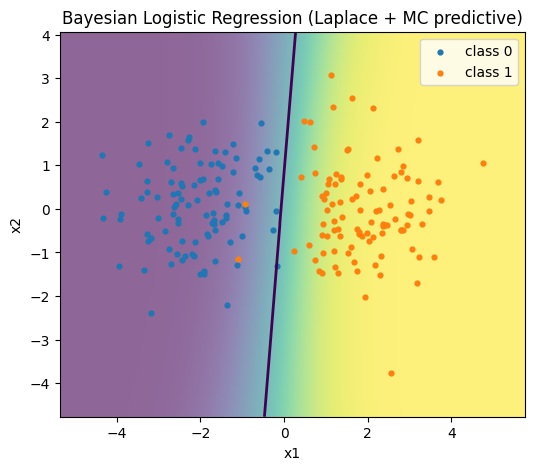

Converged: True iters: 7
MAP: [ 0.1521  2.028  -0.1709]


In [11]:

import numpy as np
import matplotlib.pyplot as plt
from bayes_fp import newton_map_logistic, laplace_covariance, predictive_laplace_mc

# --- Fit MAP & Laplace ---
w_hat, H_hat, info = newton_map_logistic(X, y, sigma0=0.5, verbose=False)
Sigma = laplace_covariance(H_hat)

x1_min, x1_max = X[:,1].min()-1.0, X[:,1].max()+1.0
x2_min, x2_max = X[:,2].min()-1.0, X[:,2].max()+1.0
nx, ny = 200, 200
gx = np.linspace(x1_min, x1_max, nx)
gy = np.linspace(x2_min, x2_max, ny)
G1, G2 = np.meshgrid(gx, gy)
G = np.c_[np.ones(G1.size), G1.ravel(), G2.ravel()]

def predictive_grid(Xgrid, batch=20000, nsamples=5000, seed=42):
    probs = np.empty(Xgrid.shape[0], dtype=float)
    start = 0
    while start < Xgrid.shape[0]:
        end = min(start + batch, Xgrid.shape[0])
        probs[start:end] = predictive_laplace_mc(Xgrid[start:end], w_hat, Sigma, nsamples=nsamples, seed=seed+start)
        start = end
    return probs

grid_probs = predictive_grid(G, batch=20000, nsamples=3000, seed=123)
Z = grid_probs.reshape(G1.shape)

# --- Plot: probability heatmap ---
fig, ax = plt.subplots(figsize=(6, 5))

im = ax.imshow(
    Z,
    extent=[x1_min, x1_max, x2_min, x2_max],
    origin="lower",
    aspect="auto",
    alpha=0.6,
)

cs = ax.contour(gx, gy, Z, levels=[0.5], linewidths=2)

# Training points
ax.scatter(X0[:,0], X0[:,1], s=12, label="class 0")
ax.scatter(X1[:,0], X1[:,1], s=12, label="class 1")

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Bayesian Logistic Regression (Laplace + MC predictive)")
ax.legend(loc="upper right")

plt.show()

print("Converged:", info.get("converged", None), "iters:", info.get("num_iter", None))
print("MAP:", np.array2string(w_hat, precision=4))



In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# Fit sklearn logistic regression (MLE)
clf = LogisticRegression(penalty=None, solver="lbfgs", max_iter=1000)
clf.fit(X, y)

# Predictions from sklearn
p_sklearn = clf.predict_proba(X)[:, 1]

# Predictions from MAP estimate
p_map = sigmoid(X @ w_hat)


print("Log-loss (MAP):     ", log_loss(y, p_map))
print("Log-loss (sklearn):", log_loss(y, p_sklearn))


Log-loss (MAP):      0.08134852109328876
Log-loss (sklearn): 0.056518983606605976


Comparison between sklearn and my implementation

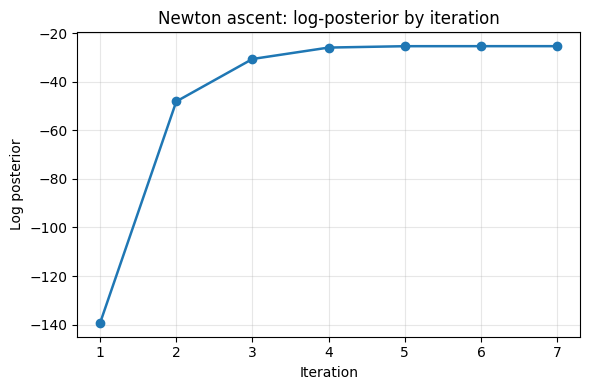

In [8]:
import numpy as np
import matplotlib.pyplot as plt

lp = info["logpost_hist"]
iters = np.arange(1, len(lp) + 1)

plt.figure(figsize=(6,4))
plt.plot(iters, lp, marker="o", linewidth=1.8)
plt.xlabel("Iteration")
plt.ylabel("Log posterior")
plt.title("Newton ascent: log-posterior by iteration")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
